# Улучшение обучения


In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision as tv
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

## Загрузка датасета

Загрузим и подготовим датасет Симпсонов для классификации.

In [19]:
# загрузим датасет со своего Google Drive

# предварительно необходимо скачать датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создать zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загрузить на свой google drive в папку netology_dl_sem

from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!mkdir -p data

!cp drive/MyDrive/netology_dl_sem/test.zip data/
!cp drive/MyDrive/netology_dl_sem/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

Все данные теперь находятся в папке `data`.

Структура трейн данных (`simpsons_dataset/`) следующая:


 \\
-- class_name_0 \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_n \\
... \\
-- class_name_k \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_m \\


Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

In [21]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


В случае описанного выше строения хранящихся данных для создания датасета очень удобен `ImageFolder`.

Хоть авторы библиотеки это и не задумывали, но аргумент `is_valid_file` нам пригодился для разбиения на `train` и `val`.

Применим дополнительную аугментацию к тренировочному датасету и переведем в тензоры все изображения.

In [22]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomGrayscale(p=0.1), ## Перевод в ч/б изображение случайных 10% картинок
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [23]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Посмотрим на изображения из `val` и `train`

In [24]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

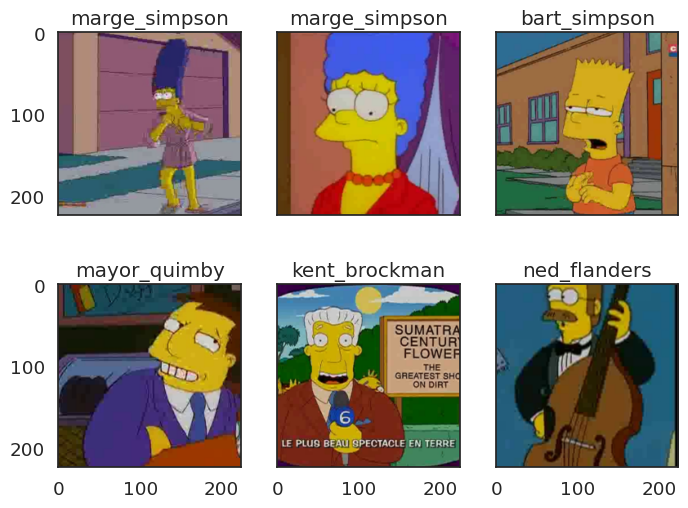

In [25]:
show_images(val_dataset)

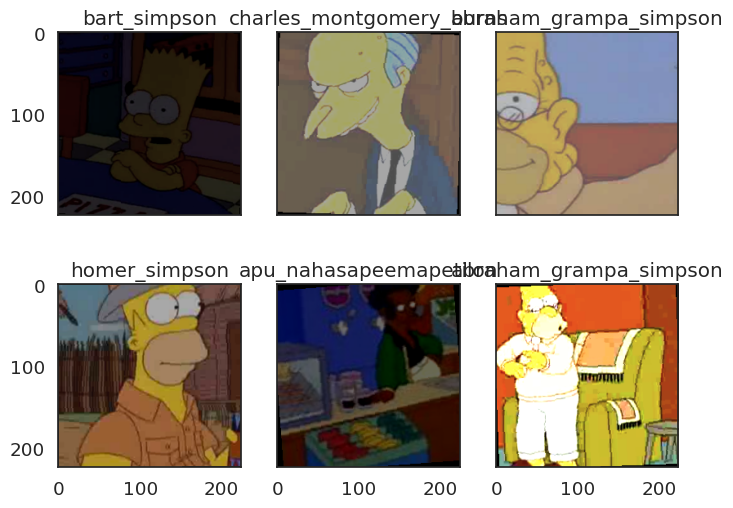

In [26]:
show_images(train_dataset)

Картинки из `train` выглядят немного изменёнными по сравнению с `val`:
К `train` применялись дополнительные аугментации `ColorJitter`, `RandomAffine`, `RandomGrayscale` чтобы увеличить размер датасета и обобщающую способность сети.
К `val` никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.

**Создадим DataLoader-ы и функции для обучения**

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [29]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Делаем шаг согласно расписанию
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [30]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

## VGG 16

Импортируем модель VGG


In [ ]:
from torchvision.models import vgg16

In [ ]:
# model = tv.models.vgg16(pretrained=True, progress=False)
model = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 111MB/s]


Будем использовать сеть как `Feature Extractor`

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Заморозим все слои сети:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=42)

Epoch 10 of 10 took 218.879s
  training loss (in-iteration): 	2.627020
  validation loss (in-iteration): 	2.405215
  training accuracy: 			28.07 %
  validation accuracy: 			39.91 %


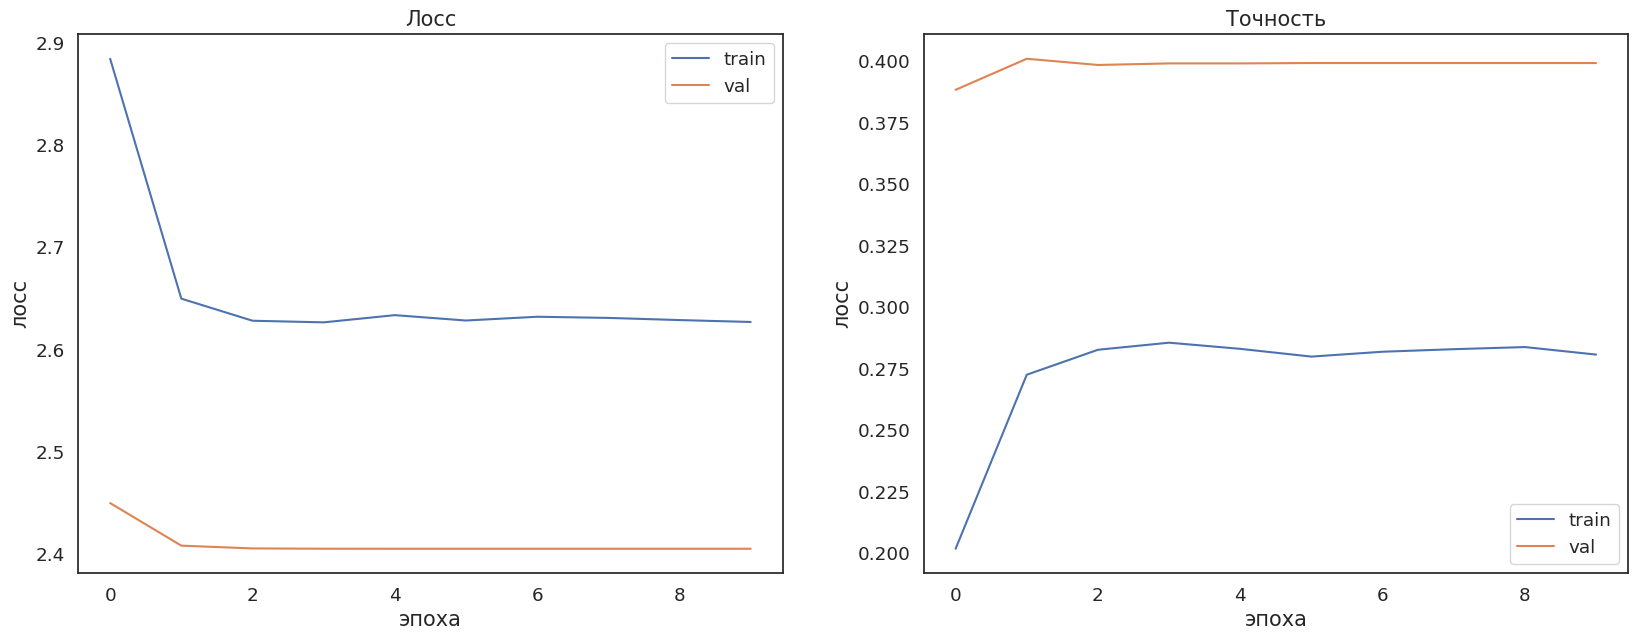

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)


clf_model, history = train(
    model, criterion, optimizer,
    scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

## EfficientNet

In [ ]:
ef_net = tv.models.efficientnet_b0(pretrained=True)

Возьмем сеть EfficientNet и будем использовать сеть как `Feature Extractor`

In [ ]:
ef_net

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# заморозим все слои сети
for param in ef_net.parameters():
    param.requires_grad = False

In [ ]:
# добавим над feature extractor сетью классификационный слой
ef_net.classifier[1] = nn.Linear(in_features=1280, out_features=42)
ef_net = ef_net.to(device)

Epoch 10 of 10 took 151.785s
  training loss (in-iteration): 	2.254002
  validation loss (in-iteration): 	1.995676
  training accuracy: 			48.69 %
  validation accuracy: 			59.67 %


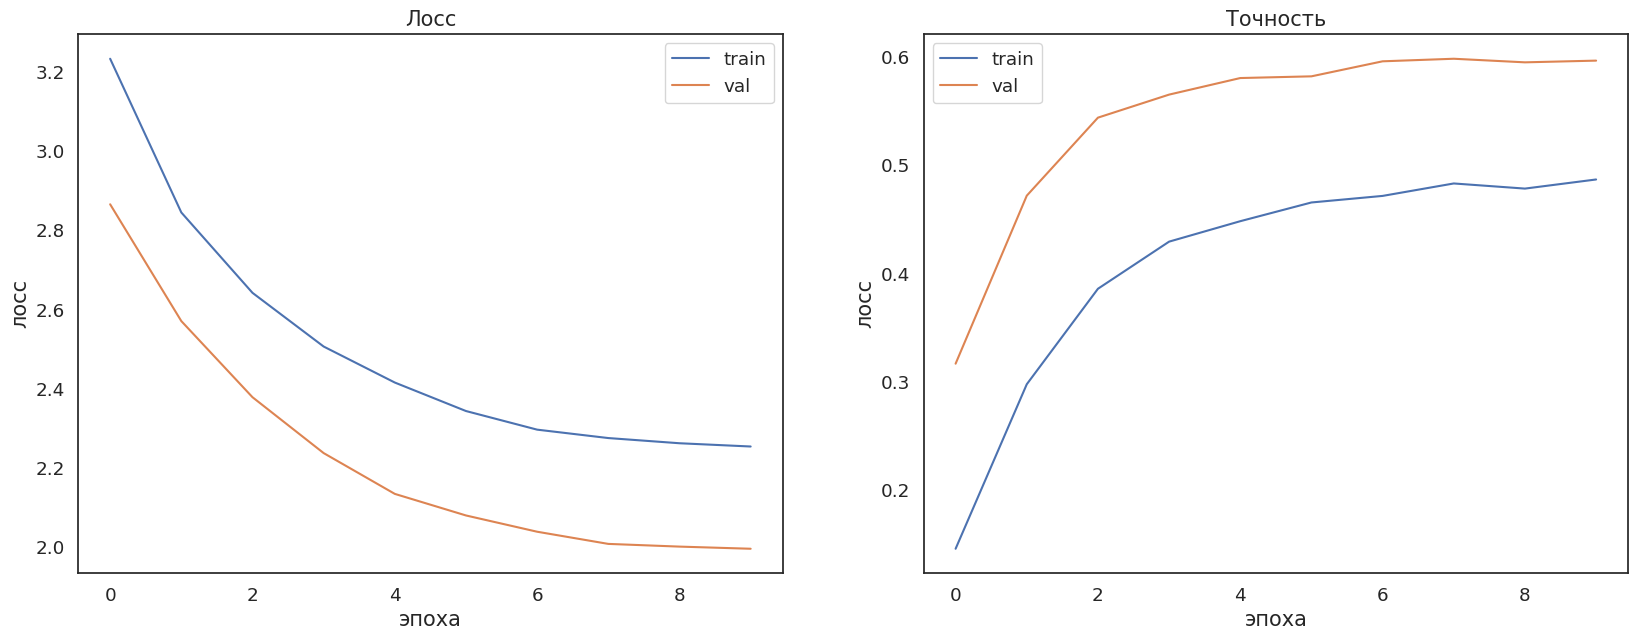

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ef_net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

clf_model, history = train(
    ef_net, criterion, optimizer,
    scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

## MobileNet. Вариант 1

In [ ]:
mob_net = tv.models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 129MB/s]


In [ ]:
mob_net

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# заморозим все слои сети
for param in mob_net.parameters():
    param.requires_grad = False

In [ ]:
mob_net.classifier[1] = nn.Linear(in_features=1280, out_features=42)
mob_net = mob_net.to(device)

Epoch 10 of 10 took 150.797s
  training loss (in-iteration): 	3.768314
  validation loss (in-iteration): 	3.765923
  training accuracy: 			2.92 %
  validation accuracy: 			2.21 %


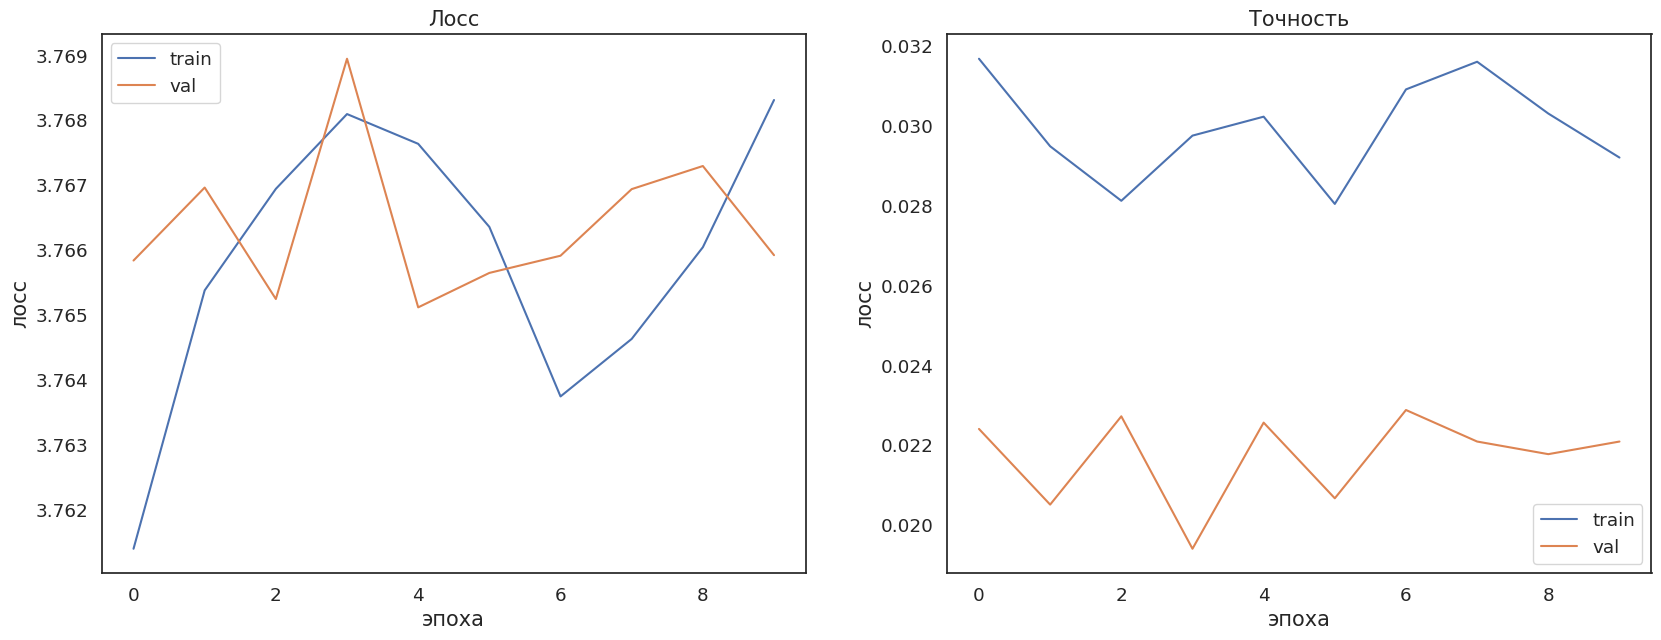

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ef_net.parameters(), lr=0.01)
lmbda = lambda epoch: 0.69 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

clf_model, history = train(
    mob_net, criterion, optimizer,
    scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Судя по графикам модель показала себя не лучшим образом. Скорее всего проблема в шаге обучения и sheduller MultiplicativeLR. Заменим.

## MobileNet. Вариант 2

Epoch 10 of 10 took 148.353s
  training loss (in-iteration): 	3.880371
  validation loss (in-iteration): 	3.887735
  training accuracy: 			1.30 %
  validation accuracy: 			1.20 %


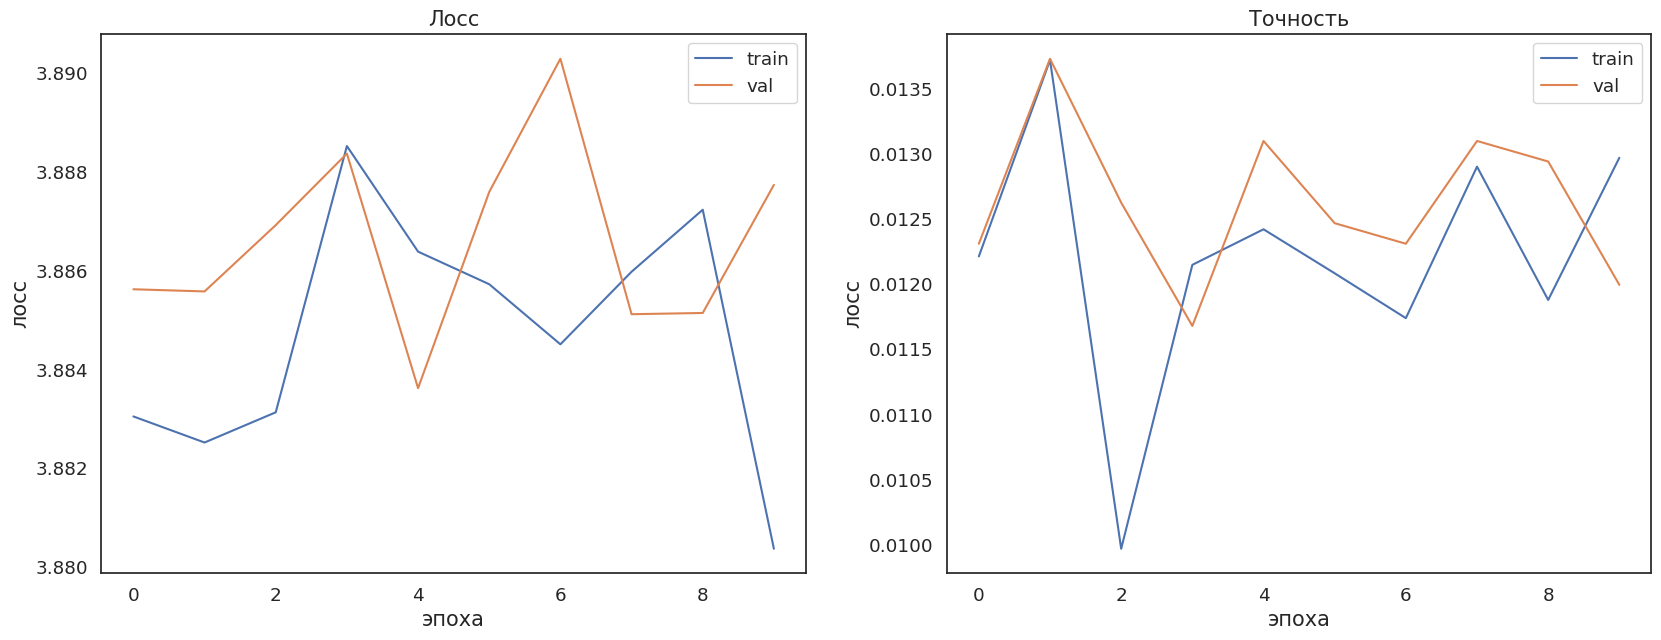

In [ ]:
mob_net = tv.models.mobilenet_v2(pretrained=True)
# заморозим все слои сети
for param in mob_net.parameters():
    param.requires_grad = False
mob_net.classifier[1] = nn.Linear(in_features=1280, out_features=42)
mob_net = mob_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ef_net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

clf_model, history = train(
    mob_net, criterion, optimizer,
    scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Нет, дело не в шаге обучения а в модели. Или в методе ее использования. Попробуем использовать модель как `FineTuning`

## MobileNet. Вариант 3
Попробуем использовать модель как FineTuning

Epoch 10 of 10 took 186.555s
  training loss (in-iteration): 	0.737537
  validation loss (in-iteration): 	0.657795
  training accuracy: 			82.26 %
  validation accuracy: 			84.01 %


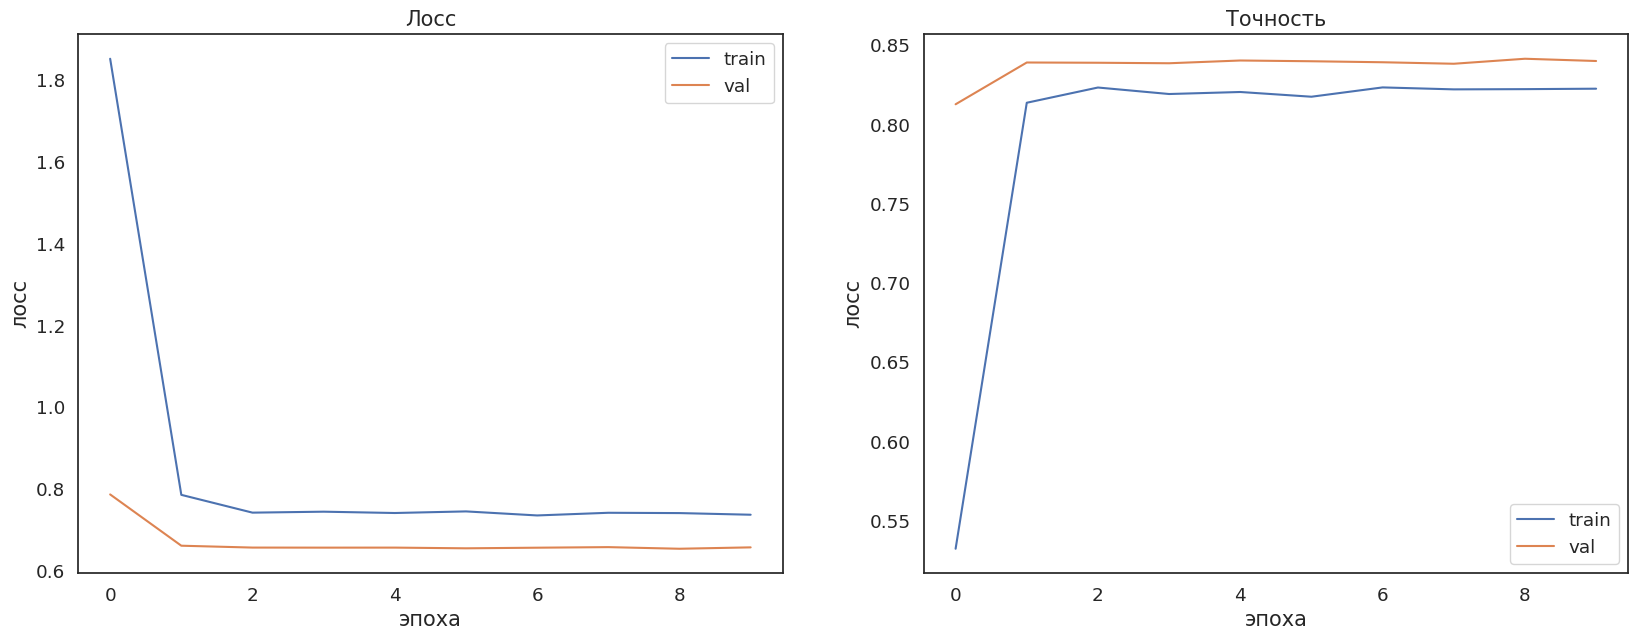

In [31]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v2', tv.models.mobilenet_v2(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

## Выводы

Были обучены 3 модели с разными алгоритмами оптимизации learning rate.
VGG 16, EfficientNet_b0, MobileNet_v2.

1. VGG 16 - предобученная модель
- scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)
  - training loss (in-iteration): 	2.627020
  - validation loss (in-iteration): 	2.405215
  - training accuracy: 			28.07 %
  - validation accuracy: 			39.91 %


2. EfficientNet_b0 - предобученная модель
- scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
  - training loss (in-iteration): 	2.254002
  - validation loss (in-iteration): 	1.995676
  - training accuracy: 			48.69 %
  - validation accuracy: 			59.67 %

3. MobileNet_v2 - предобученная модель. Вариант 1.
- lmbda = lambda epoch: 0.69 ** epoch
- scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
  - training loss (in-iteration): 	3.768314
  - validation loss (in-iteration): 	3.765923
  - training accuracy: 			2.92 %
  - validation accuracy: 			2.21 %

4. MobileNet_v2 - предобученная модель. Вариант 2.
- scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
  - training loss (in-iteration): 	3.880371
  - validation loss (in-iteration): 	3.887735
  - training accuracy: 			1.30 %
  - validation accuracy: 			1.20 %

5. MobileNet_v2 - предобученная модель. Вариант 3.
- scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)
  - training loss (in-iteration): 	0.737537
  - validation loss (in-iteration): 	0.657795
  - training accuracy: 			82.26 %
  - validation accuracy: 			84.01 %